# Connecting Drive to Colab
The first thing you want to do when you are working on Colab is mounting your Google Drive. This will enable you to access any directory on your Drive inside the Colab notebook.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Setting up PySpark in Colab

Go to where you'd like to download the installer

In [2]:
%cd /content/drive/My Drive/BigDataProject/

/content/drive/My Drive/BigDataProject


Spark is written in the Scala programming language and requires the Java Virtual Machine (JVM) to run. Therefore, our first task is to download Java.

In [3]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# Get Spark installer (check the path on spark.apache.org)

In [ ]:
# required only first time
# !wget -v https://dlcdn.apache.org/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz

# Untar the Spark installer

In [4]:
!tar -xvf spark-3.1.2-bin-hadoop3.2.tgz

spark-3.1.2-bin-hadoop3.2/
spark-3.1.2-bin-hadoop3.2/R/
spark-3.1.2-bin-hadoop3.2/R/lib/
spark-3.1.2-bin-hadoop3.2/R/lib/sparkr.zip
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/worker/
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/worker/worker.R
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/worker/daemon.R
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/tests/
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/tests/testthat/
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/tests/testthat/test_basic.R
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/profile/
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/profile/shell.R
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/profile/general.R
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/doc/
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/doc/sparkr-vignettes.html
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/doc/sparkr-vignettes.Rmd
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/doc/sparkr-vignettes.R
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/doc/index.html
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/R/
spark-3.1.2-

# Install findspark - a python library to find Spark

In [5]:
!pip install -q findspark

# Set environment variables
Set Java and Spark home based on the location where they are stored

In [6]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/drive/My Drive/BigDataProject/spark-3.1.2-bin-hadoop3.2"

# Creat a local Spark session

In [7]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

#Import Generic libraries

In [8]:
import pandas as pd
import numpy as np
from collections import OrderedDict
import csv
from pyspark.sql.functions import *

In [9]:
%cd /content/drive/My Drive/BigDataProject/ml-25m

/content/drive/My Drive/BigDataProject/ml-25m


Ratings Data File Structure (ratings.csv)
-----------------------------------------

All ratings are contained in the file `ratings.csv`. Each line of this file after the header row represents one rating of one movie by one user, and has the following format:

    userId,movieId,rating,timestamp

The lines within this file are ordered first by userId, then, within user, by movieId.

Ratings are made on a 5-star scale, with half-star increments (0.5 stars - 5.0 stars).

Timestamps represent seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970.

In [10]:
df = pd.read_csv('/content/drive/My Drive/BigDataProject/ml-25m/ratings.csv')
df.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [11]:
df = df.apply(pd.to_numeric)

In [12]:
df['rating'] = df['rating'].astype(float)

In [13]:
df.count()

userId       25000095
movieId      25000095
rating       25000095
timestamp    25000095
dtype: int64

#Taking sample from this huge dataset: Considering only 5 review per person, as this ALS theorem will take lot of time to process

In [14]:
df = df.groupby('userId').head(5)

In [15]:
df.count()

userId       812705
movieId      812705
rating       812705
timestamp    812705
dtype: int64

In [16]:
df.nunique()

userId       162541
movieId        3658
rating           10
timestamp    774003
dtype: int64

Movies Data File Structure (movies.csv)
---------------------------------------

Movie information is contained in the file `movies.csv`. Each line of this file after the header row represents one movie, and has the following format:

    movieId,title,genres

Movie titles are entered manually or imported from <https://www.themoviedb.org/>, and include the year of release in parentheses. Errors and inconsistencies may exist in these titles.

Genres are a pipe-separated list, and are selected from the following:

* Action
* Adventure
* Animation
* Children's
* Comedy
* Crime
* Documentary
* Drama
* Fantasy
* Film-Noir
* Horror
* Musical
* Mystery
* Romance
* Sci-Fi
* Thriller
* War
* Western
* (no genres listed)

In [17]:
movies = pd.read_csv('/content/drive/My Drive/BigDataProject/ml-25m/movies.csv')
movies.head(5)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [18]:
movies.count()

movieId    62423
title      62423
genres     62423
dtype: int64

# Join ratings and movies tables (left join)

In [19]:
data = pd.merge(df,movies,on='movieId',how='left')
data.count()

userId       812705
movieId      812705
rating       812705
timestamp    812705
title        812705
genres       812705
dtype: int64

In [20]:
datafiltered = data[(data.userId == 471)]
datafiltered.head(10)

,userId,movieId,rating,timestamp,title,genres
2350,471,318,4.0,1499822567,"Shawshank Redemption, The (1994)",Crime|Drama
2351,471,356,4.5,1499822674,Forrest Gump (1994),Comedy|Drama|Romance|War
2352,471,1721,4.0,1500418562,Titanic (1997),Drama|Romance
2353,471,1784,3.5,1500418530,As Good as It Gets (1997),Comedy|Drama|Romance
2354,471,2028,4.0,1500417495,Saving Private Ryan (1998),Action|Drama|War


# #Taking sample from this huge dataset: Considering 1000 users

In [21]:
df2 = data[data['userId'].between(0, 1000)]

In [22]:
df2.count()

userId       5000
movieId      5000
rating       5000
timestamp    5000
title        5000
genres       5000
dtype: int64

#Keeping only first genre for EDA 

In [23]:
def substringbeforepipe(value):
    return value.split('|')[0]

In [24]:
df2['genres'] = df2.apply(lambda x: substringbeforepipe(x.genres), axis=1)
df2.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,userId,movieId,rating,timestamp,title,genres
0,1,296,5.0,1147880044,Pulp Fiction (1994),Comedy
1,1,306,3.5,1147868817,Three Colors: Red (Trois couleurs: Rouge) (1994),Drama
2,1,307,5.0,1147868828,Three Colors: Blue (Trois couleurs: Bleu) (1993),Drama
3,1,665,5.0,1147878820,Underground (1995),Comedy
4,1,899,3.5,1147868510,Singin' in the Rain (1952),Comedy


#Here are the top 10 most rated movies:

In [25]:
common = df2.groupby('title').size().sort_values(ascending=False)[:10]
common

title
Toy Story (1995)                             340
Usual Suspects, The (1995)                   172
Twelve Monkeys (a.k.a. 12 Monkeys) (1995)    171
GoldenEye (1995)                             158
Seven (a.k.a. Se7en) (1995)                  156
Braveheart (1995)                            153
Heat (1995)                                  150
Star Wars: Episode IV - A New Hope (1977)    137
Shawshank Redemption, The (1994)             132
Jumanji (1995)                               124
dtype: int64

#Here are the top 10 most common movie genres:

In [ ]:
topG = df2.groupby('genres').size().sort_values(ascending=False)[:10]
pd.DataFrame(topG)
topG.columns =['genres', 'count']
print(topG)

genres
Action         1219
Comedy         1211
Adventure       734
Drama           653
Crime           612
Mystery         334
Children        145
Animation        40
Documentary      20
Horror           12
dtype: int64


# These are unique genres available in dataset 


In [ ]:
genres_unique = pd.DataFrame(df2.genres.str.split('|').tolist()).stack().unique()
genres_unique = pd.DataFrame(genres_unique, columns=['genre'])
print(genres_unique)

          genre
0        Comedy
1         Drama
2     Adventure
3        Action
4       Mystery
5         Crime
6      Children
7     Animation
8   Documentary
9      Thriller
10       Horror
11      Western
12       Sci-Fi
13      Romance
14      Fantasy
15      Musical


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9c92d86810>]],
      dtype=object)

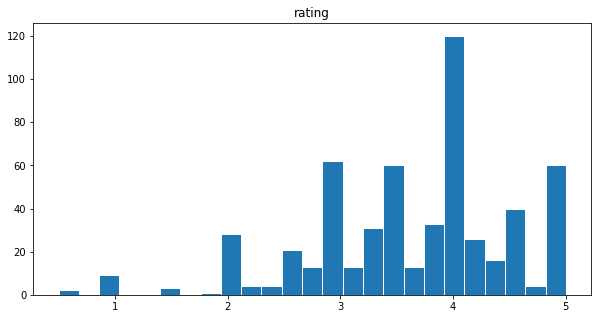

In [ ]:
df0 = df2[['movieId','rating']].groupby('movieId').mean()
df0.hist(bins=25, grid=False, edgecolor='w', label ='All genres', figsize=(10,5))

In [ ]:
ratings=spark.createDataFrame(df2)

In [ ]:
print(ratings.count())

5000


1. Handling null values - **done next**
2. Handling duplicated data - **only used inner join**
3. Transforming date formats - **date removed from final dataset**
4. Dealing with upper / lower case issues - **No changes required**
5. Handling outliers - **there are no outliers**

In [ ]:
df_naremoved = ratings.na.drop()
df_naremoved.show()

+------+-------+------+----------+--------------------+---------+
|userId|movieId|rating| timestamp|               title|   genres|
+------+-------+------+----------+--------------------+---------+
|     1|    296|   5.0|1147880044| Pulp Fiction (1994)|   Comedy|
|     1|    306|   3.5|1147868817|Three Colors: Red...|    Drama|
|     1|    307|   5.0|1147868828|Three Colors: Blu...|    Drama|
|     1|    665|   5.0|1147878820|  Underground (1995)|   Comedy|
|     1|    899|   3.5|1147868510|Singin' in the Ra...|   Comedy|
|     2|      1|   3.5|1141415820|    Toy Story (1995)|Adventure|
|     2|     62|   0.5|1141417130|Mr. Holland's Opu...|    Drama|
|     2|    110|   5.0|1141416589|   Braveheart (1995)|   Action|
|     2|    150|   4.0|1141415790|    Apollo 13 (1995)|Adventure|
|     2|    151|   4.5|1141415643|      Rob Roy (1995)|   Action|
|     3|      1|   4.0|1439472215|    Toy Story (1995)|Adventure|
|     3|     29|   4.5|1484754967|City of Lost Chil...|Adventure|
|     3|  

In [ ]:
df_naremoved.count()

5000

#**EDA**


In [ ]:
from pyspark.sql.functions import countDistinct

df2=df_naremoved.select(countDistinct("userId"))
df2.show()

df2=df_naremoved.select(countDistinct("movieId"))
df2.show()

df2=df_naremoved.select(count("rating"))
df2.show()

+----------------------+
|count(DISTINCT userId)|
+----------------------+
|                  1000|
+----------------------+

+-----------------------+
|count(DISTINCT movieId)|
+-----------------------+
|                    563|
+-----------------------+

+-------------+
|count(rating)|
+-------------+
|         5000|
+-------------+



Removing timestamp as it will be of no use in modeling

In [ ]:
df_naremoved = df_naremoved.drop(df_naremoved.timestamp)

In [ ]:
df_naremoved.show()

+------+-------+------+--------------------+---------+
|userId|movieId|rating|               title|   genres|
+------+-------+------+--------------------+---------+
|     1|    296|   5.0| Pulp Fiction (1994)|   Comedy|
|     1|    306|   3.5|Three Colors: Red...|    Drama|
|     1|    307|   5.0|Three Colors: Blu...|    Drama|
|     1|    665|   5.0|  Underground (1995)|   Comedy|
|     1|    899|   3.5|Singin' in the Ra...|   Comedy|
|     2|      1|   3.5|    Toy Story (1995)|Adventure|
|     2|     62|   0.5|Mr. Holland's Opu...|    Drama|
|     2|    110|   5.0|   Braveheart (1995)|   Action|
|     2|    150|   4.0|    Apollo 13 (1995)|Adventure|
|     2|    151|   4.5|      Rob Roy (1995)|   Action|
|     3|      1|   4.0|    Toy Story (1995)|Adventure|
|     3|     29|   4.5|City of Lost Chil...|Adventure|
|     3|     32|   4.5|Twelve Monkeys (a...|  Mystery|
|     3|     50|   5.0|Usual Suspects, T...|    Crime|
|     3|    111|   4.0|  Taxi Driver (1976)|    Crime|
|     4|  

In [ ]:
dfFinal = df_naremoved

# Data Modeling: Collaborative filtering

Only movieId, userId, and rarings required in this model

In [ ]:
from pyspark.sql.functions import col
dfM1 = dfFinal.select(col("userId"),col("movieId"),col("rating"))

In [ ]:
dfM1.count()

5000

In [ ]:
dfM1.show()

+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|     1|    296|   5.0|
|     1|    306|   3.5|
|     1|    307|   5.0|
|     1|    665|   5.0|
|     1|    899|   3.5|
|     2|      1|   3.5|
|     2|     62|   0.5|
|     2|    110|   5.0|
|     2|    150|   4.0|
|     2|    151|   4.5|
|     3|      1|   4.0|
|     3|     29|   4.5|
|     3|     32|   4.5|
|     3|     50|   5.0|
|     3|    111|   4.0|
|     4|      1|   3.0|
|     4|    260|   3.5|
|     4|    296|   4.0|
|     4|    541|   4.5|
|     4|    589|   4.0|
+------+-------+------+
only showing top 20 rows





Data split (training 80% and testing 20%)

**Recommender System by UserRatings**


In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder, CrossValidator

In [ ]:
from pyspark.mllib.recommendation import MatrixFactorizationModel
from pyspark.mllib.recommendation import Rating

In [ ]:
dfM1.printSchema()

root
 |-- userId: long (nullable = true)
 |-- movieId: long (nullable = true)
 |-- rating: double (nullable = true)



In [ ]:
(training, test) = dfM1.randomSplit([0.8,0.2], seed = 2020)

**Cold-start strategy**

When making predictions using an ALSModel, it is common to encounter users and/or items in the test dataset that were not present during training the model. This typically occurs in two scenarios:

In production, for new users or items that have no rating history and on which the model has not been trained (this is the “cold start problem”).
During cross-validation, the data is split between training and evaluation sets. When using simple random splits as in Spark’s CrossValidator or TrainValidationSplit, it is actually very common to encounter users and/or items in the evaluation set that are not in the training set
By default, Spark assigns NaN predictions during ALSModel transform when a user and/or item factor is not present in the model. This can be useful in a production system, since it indicates a new user or item, and so the system can make a decision on some fallback to use as the prediction.

However, this is undesirable during cross-validation, since any NaN predicted values will result in NaN results for the evaluation metric (for example when using RegressionEvaluator). This makes model selection impossible.

Spark allows users to set the coldStartStrategy parameter to “drop” in order to drop any rows in the DataFrame of predictions that contain NaN values. The evaluation metric will then be computed over the non-NaN data and will be valid.

**implicitPrefs**

It specifies whether to use the explicit feedback ALS variant or one adapted for implicit feedback data (defaults to false which means using explicit feedback).

In [ ]:
als = ALS(userCol='userId', itemCol='movieId', ratingCol='rating',coldStartStrategy='drop',nonnegative=True,implicitPrefs = False)

**Hyperparameters:** 

**rank** is the number of latent factors in the model (default value is 10, but we have used multiple value to obtain the optimal one).

**regParam** specifies the regularization parameter in ALS (default value is 1.0, but we have used multiple value to obtain the optimal one).


In [ ]:
param_grid = ParamGridBuilder().addGrid(als.rank, [10, 50, 100, 150]).addGrid(als.regParam, [.01, .05, .1, .15, 1.0]).build()

In [ ]:
evaluator = RegressionEvaluator(metricName='rmse',labelCol='rating',predictionCol='prediction')

In [ ]:
cv = CrossValidator(estimator=als, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=10) 

In [ ]:
model = cv.fit(training)

In [ ]:
best_model = model.bestModel

In [ ]:
predictions = best_model.transform(test)
rmse = evaluator.evaluate(predictions)

In [ ]:
print("RMSE = " + str(rmse))
print(best_model.rank)
print(best_model._java_obj.parent().getMaxIter())
print(best_model._java_obj.parent().getRegParam())

RMSE = 1.2393025970107998
150
10
0.05


In [ ]:
print("MSE = " + str(rmse*rmse))

MSE = 1.5358709269577129


In [ ]:
# Generate 10 Recommendations for all users
nrecommendations = best_model.recommendForAllUsers(10)
nrecommendations.show()

+------+--------------------+
|userId|     recommendations|
+------+--------------------+
|   471|[{1619, 4.751177}...|
|   463|[{74, 5.7272916},...|
|   833|[{1028, 4.267129}...|
|   496|[{364, 4.9720597}...|
|   148|[{82, 4.9110312},...|
|   540|[{364, 5.688767},...|
|   392|[{82, 5.797849}, ...|
|   243|[{106, 3.7272992}...|
|   623|[{171, 4.9746747}...|
|   737|[{1210, 4.9969845...|
|   897|[{1060, 5.2347264...|
|   858|[{171, 4.4267163}...|
|    31|[{82, 4.0210805},...|
|   516|[{83, 4.785206}, ...|
|   580|[{1246, 5.297627}...|
|   251|[{171, 5.047154},...|
|   451|[{1619, 4.491441}...|
|    85|[{171, 6.1247635}...|
|   137|[{83, 5.899437}, ...|
|   808|[{5952, 5.0273857...|
+------+--------------------+
only showing top 20 rows



In [ ]:
from pyspark.sql.functions import explode, col, concat_ws

nrecommendations = nrecommendations.withColumn("rec_exp", explode("recommendations")).select('userId', col("rec_exp.movieId"), col("rec_exp.rating"))
nrecommendations.limit(10).show()

+------+-------+---------+
|userId|movieId|   rating|
+------+-------+---------+
|   471|   1619| 4.751177|
|   471|     83|  4.70705|
|   471|     82|  4.70705|
|   471|    364|4.5508556|
|   471|    356|4.4083924|
|   471|    802| 4.402515|
|   471|   2571| 4.400071|
|   471|    307|4.3620768|
|   471|   1704| 4.359504|
|   471|    750|4.3593736|
+------+-------+---------+



In [ ]:
nrecommendationspd = nrecommendations.toPandas()

In [ ]:
nrecommendationspd.head()

,userId,movieId,rating
0,471,1619,4.751177
1,471,83,4.707050
2,471,82,4.707050
3,471,364,4.550856
4,471,356,4.408392


In [ ]:
nrecommendationspd.nunique()

userId     1000
movieId     310
rating     9163
dtype: int64

#Merge with Movies table to get the recommended movies title (Left join)

In [ ]:
results = pd.merge(nrecommendationspd,movies,on='movieId',how='left')
results.head(5)

,userId,movieId,rating,title,genres
0,471,1619,4.751177,Seven Years in Tibet (1997),Adventure|Drama|War
1,471,83,4.707050,Once Upon a Time... When We Were Colored (1995),Drama|Romance
2,471,82,4.707050,Antonia's Line (Antonia) (1995),Comedy|Drama
3,471,364,4.550856,"Lion King, The (1994)",Adventure|Animation|Children|Drama|Musical|IMAX
4,471,356,4.408392,Forrest Gump (1994),Comedy|Drama|Romance|War


Movies recommended to User with id = 471

In [ ]:
resultsFiltered = results[(results.userId == 471)]
resultsFiltered.head(10)

,userId,movieId,rating,title,genres
0,471,1619,4.751177,Seven Years in Tibet (1997),Adventure|Drama|War
1,471,83,4.707050,Once Upon a Time... When We Were Colored (1995),Drama|Romance
2,471,82,4.707050,Antonia's Line (Antonia) (1995),Comedy|Drama
3,471,364,4.550856,"Lion King, The (1994)",Adventure|Animation|Children|Drama|Musical|IMAX
4,471,356,4.408392,Forrest Gump (1994),Comedy|Drama|Romance|War
5,471,802,4.402515,Phenomenon (1996),Drama|Romance
6,471,2571,4.400071,"Matrix, The (1999)",Action|Sci-Fi|Thriller
7,471,307,4.362077,Three Colors: Blue (Trois couleurs: Bleu) (1993),Drama
8,471,1704,4.359504,Good Will Hunting (1997),Drama|Romance
9,471,750,4.359374,Dr. Strangelove or: How I Learned to Stop Worr...,Comedy|War


In [ ]:
from pyspark.sql.functions import concat_ws, collect_list

dfAns = nrecommendations.groupBy("userId").agg(concat_ws(",", collect_list(col("movieId")) ))
dfAns.show(5)

+------+-----------------------------------+
|userId|concat_ws(,, collect_list(movieId))|
+------+-----------------------------------+
|   471|               1619,83,82,364,35...|
|   463|               74,1968,1246,41,8...|
|   833|               1028,236,171,364,...|
|   496|               364,1028,82,83,10...|
|   148|               82,83,750,307,471...|
+------+-----------------------------------+
only showing top 5 rows



In [ ]:
dfAns.dtypes

[('userId', 'int'), ('concat_ws(,, collect_list(movieId))', 'string')]

In [ ]:
dfAnswer = dfAns.withColumnRenamed("concat_ws(,, collect_list(movieId))","Top 10 recommendations")


In [ ]:
dfAnswer.show()

+------+----------------------+
|userId|Top 10 recommendations|
+------+----------------------+
|   471|  1619,83,82,364,35...|
|   463|  74,1968,1246,41,8...|
|   833|  1028,236,171,364,...|
|   496|  364,1028,82,83,10...|
|   148|  82,83,750,307,471...|
|   540|  364,82,83,2028,17...|
|   392|  82,83,1619,5952,7...|
|   243|  106,1246,246,1438...|
|   623|  171,101,364,7,82,...|
|   737|  1210,1286,260,750...|
|   897|  1060,50,953,178,3...|
|   858|  171,101,1028,1,20...|
|    31|  82,83,1246,1653,1...|
|   516|  83,82,364,610,124...|
|   580|  1246,82,83,364,19...|
|   251|  171,101,7,364,233...|
|   451|  1619,170,1772,196...|
|    85|  171,101,17,7,28,1...|
|   137|  83,82,364,307,161...|
|   808|  5952,750,1210,608...|
+------+----------------------+
only showing top 20 rows



In [ ]:
dfFinalPd = dfAnswer.toPandas()
dfFinalPd.head()

,userId,Top 10 recommendations
0,471,"1619,83,82,364,356,802,2571,307,1704,750"
1,463,"74,1968,1246,41,82,83,750,1200,337,364"
2,833,"1028,236,171,364,2028,41,34,83,82,1073"
3,496,"364,1028,82,83,1073,199,236,1968,750,2028"
4,148,"82,83,750,307,471,1200,1438,364,1246,1968"


In [ ]:
#spark df to csv -> output
dfFinalPd.to_csv('/content/RecommendationsM1.txt', sep ='\t')